In [1]:
!pip install pyspark_dist_explore

from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
from pyspark.sql.functions import trim
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
spark = SparkSession.builder.master("spark://spark:7077").appName("Static Spectra ML").getOrCreate()

In [3]:
data = spark.read.parquet("../data/spectra/spectra.parquet")

AnalysisException: 'Path does not exist: file:/home/jovyan/data/spectra/spectra.parquet;'

In [ ]:
data.dtypes

In [ ]:
data.count()

## Analysis of chosen columns

### Declination

In [ ]:
data.describe(['dec']).show()

In [ ]:
data_dec = data.select('dec')
fig, ax = plt.subplots()
hist(ax, data_dec, bins = 100, color=['red']);

### Epoch of the period (given in modified julian date)

In [ ]:
data.describe(['mjd']).show()

In [ ]:
data_dec = data.select('mjd')
fig, ax = plt.subplots()
hist(ax, data_dec, bins = 100, color=['red']);

### Fiber

In [ ]:
data.describe(['fiber']).show()

In [ ]:
data_dec = data.select('fiber')
fig, ax = plt.subplots()
hist(ax, data_dec, bins = 100, color=['red']);

### Plate

In [ ]:
data.describe(['plate']).show()

In [ ]:
data_dec = data.select('plate')
fig, ax = plt.subplots()
hist(ax, data_dec, bins = 100, color=['red']);

### Right ascension

In [ ]:
data.describe(['ra']).show()

In [ ]:
data_dec = data.select('ra')
fig, ax = plt.subplots()
hist(ax, data_dec, bins = 100, color=['red']);

### Size

In [ ]:
data.describe(['size']).show()

In [ ]:
data_dec = data.select('size')
fig, ax = plt.subplots()
hist(ax, data_dec, bins = 1000, color=['red']);

### Redshift

In [ ]:
data.describe(['z']).show()

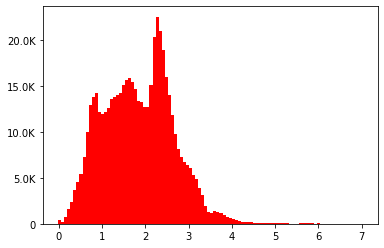

In [19]:
data_dec = data.select('z')
fig, ax = plt.subplots()
hist(ax, data_dec, bins = 100, color=['red']);

## Logistic regression with no feature engineering: type

In [61]:
lr_data = data.select('dec', 'ra', 'z', 'mjd', 'fiber', 'type', 'size')

In [62]:
lr_data.select('type').distinct().show()

+------+
|  type|
+------+
|GALAXY|
|QSO   |
|   QSO|
|STAR  |
|  STAR|
+------+



In [65]:
lr_data = lr_data.withColumn('type', trim(lr_data.type))

#### Trim the type strings

In [66]:
lr_data.groupBy(lr_data.type).count().show()

+------+------+
|  type| count|
+------+------+
|GALAXY|  1190|
|   QSO|524883|
|  STAR|   241|
+------+------+



Prepare the data for analysis: assemble dec, fiber, mjd, plate, ra, size and z into features vector column.

In [23]:
assembler = VectorAssembler(inputCols = ['mjd', 'dec', 'fiber', 'ra', 'size', 'z'], outputCol= 'features')
assembled_df = assembler.transform(lr_data)
assembled_df = assembled_df.select('type', 'features')
assembled_df.show(3)

+----+--------------------+
|type|            features|
+----+--------------------+
| QSO|[55569.0,13.87047...|
| QSO|[55569.0,13.53438...|
| QSO|[55569.0,13.53085...|
+----+--------------------+
only showing top 3 rows



Encode type column using StringIndexer

In [36]:
indexer = StringIndexer(inputCol='type', outputCol='type_index')
indexed_data = indexer.fit(assembled_df).transform(assembled_df)
indexed_data = indexed_data.select('features', 'type_index', 'type')
indexed_data.show(3)

+--------------------+----------+----+
|            features|type_index|type|
+--------------------+----------+----+
|[55569.0,13.87047...|       0.0| QSO|
|[55569.0,13.53438...|       0.0| QSO|
|[55569.0,13.53085...|       0.0| QSO|
+--------------------+----------+----+
only showing top 3 rows



In [37]:
indexed_data.select('type_index', 'type').distinct().show()

+----------+------+
|type_index|  type|
+----------+------+
|       0.0|   QSO|
|       2.0|  STAR|
|       1.0|GALAXY|
+----------+------+



Split the data into training and testing parts

In [26]:
splits = indexed_data.randomSplit([0.7, 0.3])
train_data = splits[0]
test_data = splits[1]

In [27]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'type_index')
lr_model = lr.fit(train_data)

Summary of the training:

In [28]:
summary = lr_model.summary

Objective per iteration:

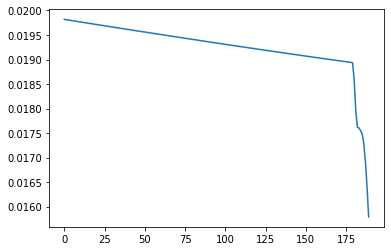

In [29]:
objectiveHistory = summary.objectiveHistory
plt.plot(range(len(objectiveHistory)), objectiveHistory);

In [30]:
print("False positive rate by label:")
for i, rate in enumerate(summary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

False positive rate by label:
label 0: 0.9383215369059656
label 1: 8.166665305555782e-06
label 2: 0.0


Rates by label aren't very informative, since the counts differ greatly (the count of QSOs is far larger that other 2 types)

In [33]:
print("Precision by label:")
for i, rate in enumerate(summary.precisionByLabel):
    print("label %d: %s" % (i, rate))

Precision by label:
label 0: 0.9974789733336231
label 1: 0.9508196721311475
label 2: 0.0


In [35]:
accuracy = summary.accuracy
falsePositiveRate = summary.weightedFalsePositiveRate
truePositiveRate = summary.weightedTruePositiveRate
fMeasure = summary.weightedFMeasure()
precision = summary.weightedPrecision
recall = summary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Accuracy: 0.9974712425135469
FPR: 0.9358009460848181
TPR: 0.9974712425135469
F-measure: 0.9963482013756904
Precision: 0.9969120095732882
Recall: 0.9974712425135469


### Improvements

##### Standard scale all columns

In [48]:
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scalerModel = scaler.fit(indexed_data)
scaled_data = scalerModel.transform(indexed_data)

In [49]:
splits = scaled_data.randomSplit([0.7, 0.3])
train_data = splits[0]
test_data = splits[1]

In [50]:
lr_scaled = LogisticRegression(featuresCol = 'features', labelCol = 'type_index')
lr_model = lr_scaled.fit(train_data)

In [55]:
summary = lr_model.summary

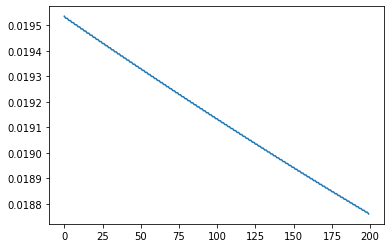

In [52]:
objectiveHistory = summary.objectiveHistory
plt.plot(range(len(objectiveHistory)), objectiveHistory);

In [56]:
accuracy = summary.accuracy
falsePositiveRate = summary.weightedFalsePositiveRate
truePositiveRate = summary.weightedTruePositiveRate
fMeasure = summary.weightedFMeasure()
precision = summary.weightedPrecision
recall = summary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Accuracy: 0.9973533975148022
FPR: 0.9973533975148022
TPR: 0.9973533975148022
F-measure: 0.9960318497187198
Precision: 0.994713799534319
Recall: 0.9973533975148022


# Subtypes classification with no feature engineering

In [67]:
lr_data = data.select('dec', 'ra', 'z', 'mjd', 'fiber', 'subtype', 'size')

In [68]:
lr_data.select('subtype').distinct().show()

+--------------------+
|             subtype|
+--------------------+
|      F8V (G_243-63)|
|L5.5             ...|
|      M5III (221615)|
|      F3/F5V (30743)|
|        A5II (34578)|
|        A2II (39866)|
|         M1 (204445)|
|      M8IIIe (84748)|
|STARBURST        ...|
|        O8e (188001)|
|M9               ...|
|                 AGN|
|       G0 (G_101-29)|
|   M4.5:III (123657)|
|STARFORMING      ...|
|L9               ...|
|              Carbon|
|    G5/G6IVw (26297)|
|O                ...|
|       A0IVn (25642)|
+--------------------+
only showing top 20 rows



In [71]:
lr_data = lr_data.withColumn('subtype', trim(lr_data.subtype))
lr_data.groupBy(lr_data.subtype).count().show()

+-------------------+-----+
|            subtype|count|
+-------------------+-----+
|     F8V (G_243-63)|    3|
|     M5III (221615)|    4|
|     F3/F5V (30743)|    5|
|       A5II (34578)|    1|
|       A2II (39866)|    1|
|        M1 (204445)|    2|
|     M8IIIe (84748)|    1|
|                 M4|    1|
|       O8e (188001)|    1|
|                AGN|  125|
|      G0 (G_101-29)|    2|
|  M4.5:III (123657)|    4|
|             Carbon|    3|
|   G5/G6IVw (26297)|    2|
|      A0IVn (25642)|    1|
|B0.5Ibe... (187459)|    1|
|       A6IV (28527)|    1|
|      A4 (G_165-39)|    4|
|        K0V (10780)|    1|
|                 CV|   15|
+-------------------+-----+
only showing top 20 rows



In [72]:
assembler = VectorAssembler(inputCols = ['mjd', 'dec', 'fiber', 'ra', 'size', 'z'], outputCol= 'features')
assembled_df = assembler.transform(lr_data)
assembled_df = assembled_df.select('subtype', 'features')
assembled_df.show(3)

+---------+--------------------+
|  subtype|            features|
+---------+--------------------+
|BROADLINE|[55569.0,13.87047...|
|BROADLINE|[55569.0,13.53438...|
|         |[55569.0,13.53085...|
+---------+--------------------+
only showing top 3 rows



Some rows do not contain subtypes. Drop them:

In [76]:
dropped_df = assembled_df.filter("subtype != ''")
dropped_df.show()

+---------+--------------------+
|  subtype|            features|
+---------+--------------------+
|BROADLINE|[55569.0,13.87047...|
|BROADLINE|[55569.0,13.53438...|
|BROADLINE|[55569.0,13.96912...|
|BROADLINE|[55569.0,13.41349...|
|BROADLINE|[55569.0,12.78081...|
|BROADLINE|[55569.0,13.99541...|
|BROADLINE|[55569.0,13.05385...|
|BROADLINE|[55569.0,13.34644...|
|BROADLINE|[55569.0,14.03764...|
|BROADLINE|[55569.0,12.91161...|
|BROADLINE|[55569.0,12.94462...|
|BROADLINE|[55569.0,12.87180...|
|BROADLINE|[55569.0,13.28736...|
|BROADLINE|[55569.0,13.53676...|
|BROADLINE|[55569.0,13.83068...|
|BROADLINE|[55569.0,13.67767...|
|BROADLINE|[55569.0,13.21413...|
|BROADLINE|[55569.0,13.42253...|
|BROADLINE|[55569.0,13.60639...|
|BROADLINE|[55569.0,13.89438...|
+---------+--------------------+
only showing top 20 rows



In [77]:
indexer = StringIndexer(inputCol='subtype', outputCol='subtype_index')
indexed_data = indexer.fit(dropped_df).transform(dropped_df)
indexed_data = indexed_data.select('features', 'subtype_index', 'subtype')
indexed_data.show(3)

+--------------------+-------------+---------+
|            features|subtype_index|  subtype|
+--------------------+-------------+---------+
|[55569.0,13.87047...|          0.0|BROADLINE|
|[55569.0,13.53438...|          0.0|BROADLINE|
|[55569.0,13.96912...|          0.0|BROADLINE|
+--------------------+-------------+---------+
only showing top 3 rows



In [78]:
indexed_data.select('subtype_index', 'subtype').distinct().show()

+-------------+---------------+
|subtype_index|        subtype|
+-------------+---------------+
|         37.0|K3Ib... (17506)|
|         14.0|    F2V (33256)|
|         77.0|  A0IVn (25642)|
|         70.0|    A1m (78209)|
|          9.0|           L5.5|
|         41.0|             K5|
|         27.0|  K5Ve (118100)|
|         36.0|F5Ib... (17463)|
|         59.0|    K0V (10780)|
|         16.0| M5III (221615)|
|          6.0|    STARFORMING|
|          0.0|      BROADLINE|
|         35.0|   G8V (101501)|
|         42.0|    A4V (97603)|
|         55.0|       CarbonWD|
|         64.0|  K1III (18322)|
|         60.0|   A2II (39866)|
|         54.0|  G9Ib (221861)|
|         48.0|             M1|
|         58.0|   A5II (34578)|
+-------------+---------------+
only showing top 20 rows



## Logistic Regression

In [79]:
splits = indexed_data.randomSplit([0.7, 0.3])
train_data = splits[0]
test_data = splits[1]

In [81]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'subtype_index')
lr_model = lr.fit(train_data)

In [82]:
summary = lr_model.summary

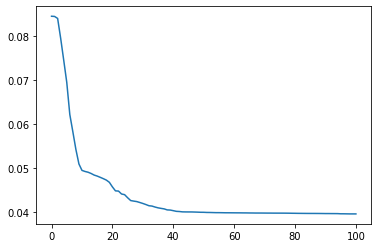

In [83]:
objectiveHistory = summary.objectiveHistory
plt.plot(range(len(objectiveHistory)), objectiveHistory);

In [84]:
accuracy = summary.accuracy
falsePositiveRate = summary.weightedFalsePositiveRate
truePositiveRate = summary.weightedTruePositiveRate
fMeasure = summary.weightedFMeasure()
precision = summary.weightedPrecision
recall = summary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Accuracy: 0.9865708493788711
FPR: 0.71913645437243
TPR: 0.9865708493788711
F-measure: 0.9837599531215878
Precision: 0.9814130253955163
Recall: 0.9865708493788711


## Decision Tree Classifier

In [85]:
splits = indexed_data.randomSplit([0.7, 0.3])
train_data = splits[0]
test_data = splits[1]

In [87]:
dt = DecisionTreeClassifier(labelCol='subtype_index', featuresCol='features')

In [100]:
data_model = dt.fit(train_data)
predictions = data_model.transform(test_data)

In [101]:
predictions.select("prediction", "subtype_index", "features").show(5)

+----------+-------------+--------------------+
|prediction|subtype_index|            features|
+----------+-------------+--------------------+
|       0.0|          0.0|[55274.0,-0.53436...|
|       0.0|          0.0|[55274.0,-0.47085...|
|       0.0|          0.0|[55274.0,-0.36916...|
|       0.0|          0.0|[55274.0,-0.29529...|
|       0.0|          0.0|[55274.0,-0.16058...|
+----------+-------------+--------------------+
only showing top 5 rows



In [102]:
evaluator = MulticlassClassificationEvaluator(labelCol="subtype_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (1.0 - accuracy))

Test Error = 0.0135753 


## Random Forest Classifier

In [103]:
splits = indexed_data.randomSplit([0.7, 0.3])
train_data = splits[0]
test_data = splits[1]

In [104]:
rf = RandomForestClassifier(labelCol="subtype_index", predictionCol="prediction")

In [105]:
model = rf.fit(train_data)
predictions = model.transform(test_data)

In [107]:
predictions.select("prediction", "subtype_index", "features").show(5)

+----------+-------------+--------------------+
|prediction|subtype_index|            features|
+----------+-------------+--------------------+
|       0.0|          0.0|[55274.0,-1.21377...|
|       0.0|          0.0|[55274.0,-0.53436...|
|       0.0|          0.0|[55274.0,-0.26575...|
|       0.0|          0.0|[55274.0,-0.05379...|
|       0.0|          0.0|[55274.0,0.131242...|
+----------+-------------+--------------------+
only showing top 5 rows



In [106]:
evaluator = MulticlassClassificationEvaluator(labelCol="subtype_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (1.0 - accuracy))

Test Error = 0.0132728 


## Linear Support Vector Machine